In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier
print("xgboost", xgboost.__version__)

from catboost import CatBoostClassifier

import lightgbm
from lightgbm import LGBMClassifier
print("lightgbm",lightgbm.__version__)

xgboost 1.5.1
lightgbm 3.3.1


# Описание задачи

Построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска.

https://dsbattle.com/hackathons/mkb/
    
https://hackathon-mkb.ru 


Модель оценки вероятности предъявления по гарантии для 
клиентов МСБ.

Для  заключения  контрактов  в  рамках  системы  госзакупок  поставщикам 
товаров / услуг необходимо получить гарантию исполнения контракта со 
стороны  банков.  В  случае,  если  поставщик  не  выполнит  контракт, 
заказчик  предъявит  денежное  требование  выдавшему  гарантию  банку. 
Для того, чтобы минимизировать потери от кредитного риска, необходима 
модель, прогнозирующая вероятность предъявления по гарантии.  
Задача  заключается  в  построении  аппликационной  модели  оценки 
вероятности  предъявления  по  отдельной  гарантии.  В  качестве 
предикторов  для  моделирования  используются  данные  о  клиенте, 
включая различные собранные «анкетные» данные, а также финансовые 
показатели компаний. Поставщиками могут быть как юридические лица, 
так  и  индивидуальные  предприниматели.  Соответственно,  некоторые 
данные могут быть присущи только ИП или только ЮЛ. Для построения 
модели используется основная выборка (17 891 наблюдения), в которой 
указана  целевая  переменная  –  факт  предъявления  по  гарантии.  В 
качестве  результата  по  всем  наблюдениям  необходимо  получить 
балльную оценку и значение вероятности предъявления по гарантии. 
Для  выявления  победителя  будет  произведена  качественная  оценка 
построенной модели  на тестовой выборке (7 330 наблюдений), которую 
необходимо проскорить в соответствии с построенной моделью. Помимо 
качества  дифференцирующей  способности,  будет  учтена 
интерпретируемость модели. 

Решения оцениваются по метрике ROC/AUC Score (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.



### Описание признаков

* id_contract	Идентификатор контракта
* id_client	Идентификатор клиента
* SIGN_DATE	Дата подписания контракта
* IP_flag	Флаг ИП
* TARGET	Целевая переменная - факт наличия предъявления по гарантии
* F1100	Внеоборотные активы
* F1110	Нематериальные активы
* F1150	Основные средства
* F1160	Доходные вложения в материальные ценности
* F1170	Долгосрочные финансовые вложения
* F1180	Отложенные налоговые активы
* F1190	Прочие внеоборотные активы
* F1200	Оборотные активы
* F1210	Запасы
* F1220	НДС по приобретенным ценностям
* F1230	Дебиторская задолженность
* F1240	Краткосрочные финансовые вложения
* F1250	Денежные средства и денежные эквиваленты
* F1260	Прочие оборотные активы
* F1300	Капитал и резервы
* F1310	Уставный капитал
* F1320	Собственные акции, выкупленные у акционеров
* F1350	Добавочный капитал
* F1360	Резервный капитал
* F1370	Нераспределенная прибыль (непокрытый убыток)
* F1400	Долгосрочные обязательства
* F1410	Заёмные средства (долгосрочные)
* F1420	Отложенные налоговые обязательства
* F1450	Прочие долгосрочные обязательства
* F1500	Краткосрочные обязательства
* F1510	Заёмные средства (краткосрочные)
* F1520	Кредиторская задолженность
* F1530	Доходы будущих периодов
* F1550	Прочие краткосрочные обязательства
* F1600	Активы  всего
* F1700	Пассивы всего
* F2100	Валовая прибыль (убыток)
* F2110	Выручка
* F2120	Себестоимость продаж
* F2200	Прибыль (убыток) от продажи
* F2210	Коммерческие расходы
* F2220	Управленческие расходы
* F2300	Прибыль (убыток) до налогообложения
* F2310	Доходы от участия в других организациях
* F2320	Проценты к получению
* F2330	Проценты к уплате
* F2340	Прочие доходы
* F2350	Прочие расходы
* F2400	Чистая прибыль (убыток)
* F2410	Текущий налог на прибыль
* F1150_LAG1	Основные средства (предыдущий период)
* F1230_LAG1	Дебиторская задолженность (предыдущий период)
* F1410_LAG1	Заёмные средства (долгосрочные) (предыдущий период)
* F1510_LAG1	Заёмные средства (краткосрочные) (предыдущий период)
* F1520_LAG1	Кредиторская задолженность (предыдущий период)
* F2110_LAG1	Выручка (предыдущий период)
* F2120_LAG1	Себестоимость продаж (предыдущий период)
* F2200_LAG1	Прибыль (убыток) от продажи (предыдущий период)
* F2210_LAG1	Коммерческие расходы (предыдущий период)
* F2220_LAG1	Управленческие расходы (предыдущий период)
* F2300_LAG1	Прибыль (убыток) до налогообложения (предыдущий период)
* F2320_LAG1	Проценты к получению (предыдущий период)
* F2330_LAG1	Проценты к уплате (предыдущий период)
* F2400_LAG1	Чистая прибыль (убыток) (предыдущий период)
* EGRPOINCLUDED	Признак включения в ЕГРПО (Росстат)
* DATEFIRSTREG	Дата регистрации
* OKFS_GROUP	Группа ОКФС
* OKOPF_GROUP	Группа ОКОПФ
* OKOGU_GROUP	Группа ОКОГУ
* OKATO_REGIONCODE	ОКАТО. Код региона
* OKATO_FED	Код федерального округа по ОКАТО
* OKTMO_CODE	ОКТМО. Код
* OKTMO_FED	Код федерального округа по ОКОТМО
* WORKERSRANGE	Диапазон численности персонала
* TAXREG_REGDATE	Регистрация в ФНС. Дата регистрации
* TAXREGPAY_REGDATE	Регистрация в налоговом органе. Дата регистрации
* COUNTCOOWNERFCSM	Структура компании. Количество совладельцев (Данные компании/ФСФР)
* COUNTCOOWNERROSSTAT	Структура компании. Количество совладельцев (Ростат)
* COUNTCOOWNEREGRUL	Структура компании. Количество совладельцев (ЕГРЮЛ)
* COUNTBRANCH	Структура компании. Количество филиалов (Данные компании)
* COUNTBRANCHROSSTAT	Структура компании. Количество филиалов (Росстат)
* COUNTBRANCHEGRUL	Структура компании. Количество филиалов (ЕГРЮЛ)
* TELEPHONECOUNT	Количество компаний с аналогичными телефоном
* MANAGERCOUNTINCOUNTRY	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди всех действующих компаний)
* MANAGERCOUNTINREGION	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди действующих компаний, зарегистрированных в том же регионе)
* MANAGERINNCOUNT	Количество компаний с аналогичным ИНН руководителя (поиск по ИНН руководителя среди всех действующих компаний)
* OKVED_CODE	ОКВЭД
* PLAINTIFF_CASESNUMBER_YEAR	Участие в арбитражных делах в качестве истца. Количество дел (за последний год)
* PLAINTIFF_SUM_YEAR	Участие в арбитражных делах в качестве истца. Сумма, руб. (за последний год)
* DEFENDANT_CASESNUMBER_YEAR	Участие в арбитражных делах в качестве ответчика. Количество дел (за последний год)
* DEFENDANT_SUM_YEAR	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за последний год)
* THIRDOROTHERPERSON_YEAR	Участие в арбитражных делах в качестве третьего лица. (за последний год)
* PLAINTIFF_CASESNUMBER_EVER	Участие в арбитражных делах в качестве истца. Количество дел (за все время)
* PLAINTIFF_SUM_EVER	Участие в арбитражных делах в качестве истца. Сумма, руб. (за все время)
* DEFENDANT_CASESNUMBER_EVER	Участие в арбитражных делах в качестве ответчика. Количество дел (за все время)
* DEFENDANT_SUM_EVER	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за все время)
* THIRDOROTHERPERSON_EVER	Участие в арбитражных делах в качестве третьего лица. (за все время)
* ADMITTEDNUMBER_233_YEAR	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 223)
* NOTADMITTEDNUMBER_233_YEAR	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 223)
* WINNERNUMBER_233_YEAR	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 223)
* SIGNEDNUMBER_233_YEAR	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 223)
* SUM_233_YEAR	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 223)
* ADMITTEDNUMBER_233_EVER	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 223)
* NOTADMITTEDNUMBER_233_EVER	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 223)
* WINNERNUMBER_233_EVER	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 223)
* SIGNEDNUMBER_233_EVER	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 223)
* SUM_233_EVER	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 223)
* ADMITTEDNUMBER_95_YEAR	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 94)
* NOTADMITTEDNUMBER_95_YEAR	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 94)
* WINNERNUMBER_95_YEAR	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 94)
* SIGNEDNUMBER_95_YEAR	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 94)
* SUM_95_YEAR	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 94)
* ADMITTEDNUMBER_95_EVER	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 94)
* NOTADMITTEDNUMBER_EVER	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 94)
* WINNERNUMBER_95_EVER	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 94)
* SIGNEDNUMBER_95_EVER	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 94)
* SUM_95_EVER	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 94)
* FLAG_DISQUALIFICATION	Наличие руководителя компании, дисквалифицированного когда-либо
* COUNT_CHANGE_YEAR	Количество изменений в наименовании и организационно-правовой форме за последний год
* COUNT_CHANGE_EVER	Количество изменений в наименовании и организационно-правовой форме за все время
* BIRTHDATE	Дата рождения
* AGE	Возраст
* SEX_NAME	Пол
* CITIZENSHIP_NAME	Гражданство

## 1 EDA

In [2]:
# считываем данные

train_data = pd.read_csv("../data/external/train_dataset_hackathon_mkb.csv", sep=';', encoding='cp1251')
test_data = pd.read_csv("../data/external/test_dataset_hackathon_mkb.csv", sep=';', encoding='cp1251')

print(train_data.shape)
print(test_data.shape)

(17891, 124)
(7330, 123)


In [3]:
train_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,17892,3620,08APR2019:00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17893,4101,08APR2019:00:00:00,0,1906000.0,NaN,1906000.0,NaN,NaN,NaN,...,7439.0,7100.0,1.187411e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17894,9589,08APR2019:00:00:00,0,147000.0,NaN,147000.0,NaN,NaN,NaN,...,362.0,344.0,9.836260e+07,NaN,1.0,3.0,NaN,NaN,NaN,NaN
3,17895,11546,08APR2019:00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17896,12558,08APR2019:00:00:00,0,26000.0,NaN,NaN,NaN,26000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Columns: 124 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(4), object(12)
memory usage: 16.9+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Columns: 123 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(3), object(12)
memory usage: 6.9+ MB


Видим что имется много незаполненых данных, в случае ИП и ЮЛ используются разные данные

In [7]:
train_data[train_data['IP_flag'] == 1]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,10714,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,16,5567,01JAN2018:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27MAY1985:00:00:00,33.0,мужской,Российская Федерация
17,18,10092,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17873,17874,10092,05APR2019:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,17878,10762,05APR2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11AUG1983:00:00:00,36.0,мужской,Российская Федерация
17879,17880,10762,05APR2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11AUG1983:00:00:00,36.0,мужской,Российская Федерация
17883,17884,9630,05APR2019:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11SEP1983:00:00:00,36.0,мужской,Российская Федерация


In [8]:
train_data[train_data['IP_flag'] == 0]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,10099,01JAN2018:00:00:00,0,0,2.946220e+08,186000.0,2.311130e+08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2740,01JAN2018:00:00:00,0,0,2.636311e+10,14172000.0,2.227751e+10,301366000.0,145000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,07APR2019:00:00:00,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,...,382.0,381.0,45954226.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
17887,17888,838,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,193.0,184.0,134417510.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
17888,17889,10537,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,17890,1751,08APR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# посмотрим количества записей по каждому клиенту

print(train_data['id_client'].value_counts())

10092    293
5159     291
4613     278
5357     220
2483     182
        ... 
5937       1
10640      1
11817      1
3525       1
1751       1
Name: id_client, Length: 8922, dtype: int64


0    10502
1     7389
Name: TARGET, dtype: int64


<AxesSubplot:>

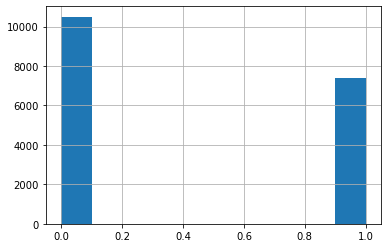

In [10]:
# посмотрим насколько сбалансированы классы

print(train_data['TARGET'].value_counts())
train_data['TARGET'].hist()

0    14391
1     3500
Name: IP_flag, dtype: int64


<AxesSubplot:>

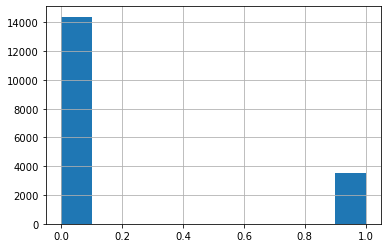

In [11]:
# посмотрим сколько клиентов являются ИП и сколько юрлицами

print(train_data['IP_flag'].value_counts())
train_data['IP_flag'].hist()

## 2 Feature selection

In [12]:
# сортируем признаки по времени и удаляем дублирующие признаки

def preprocessing(data):
    data['SIGN_DATE'] = pd.to_datetime(data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
    data['SIGN_DATE'] = pd.to_datetime(data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
    
    data = data.sort_values(by=['SIGN_DATE','id_client'])
    
    dropped_features = ['DATEFIRSTREG', 'OKTMO_FED', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'COUNTCOOWNERROSSTAT', 
                    'COUNTCOOWNEREGRUL', 'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'BIRTHDATE']
    data = data.drop(dropped_features, axis=1)
    
    return data

In [13]:
train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [14]:
train_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,SEX_NAME,CITIZENSHIP_NAME
22,23,168,2018-01-01,0,0,1.480156e+10,6000.0,6.428252e+09,175389000.0,7.944801e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,25,410,2018-01-01,0,0,6.241600e+07,NaN,5.555000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,26,562,2018-01-01,0,0,4.383630e+08,NaN,4.251110e+08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,35,822,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,27,834,2018-01-01,0,0,2.956327e+10,1358000.0,2.757412e+10,NaN,1.696519e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,...,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,SEX_NAME,CITIZENSHIP_NAME
17,17909,217,2019-04-08,0,1488000.0,NaN,1488000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,17911,471,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,101.0,89.0,23945371.0,NaN,NaN,NaN,NaN,NaN,NaN
20,17912,550,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,267.0,257.0,64529976.0,NaN,NaN,NaN,NaN,NaN,NaN
51,17943,1149,2019-04-08,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,мужской,Российская Федерация
52,17944,1400,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,848.0,843.0,317158733.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# посчитаем количество пропусков по столбцам и посмотрим на типы данных

def get_dataset_skips(dataset):
    skips = {}
    for col in dataset.columns:
        skips[col] = [dataset[col][dataset[col].isna()].shape[0], dataset[col].dtypes]
    return skips

train_skips = get_dataset_skips(train_data)
test_skips = get_dataset_skips(test_data)

In [17]:
train_skips

{'id_contract': [0, dtype('int64')],
 'id_client': [0, dtype('int64')],
 'SIGN_DATE': [0, dtype('<M8[ns]')],
 'IP_flag': [0, dtype('int64')],
 'TARGET': [0, dtype('int64')],
 'F1100': [10955, dtype('float64')],
 'F1110': [16471, dtype('float64')],
 'F1150': [11550, dtype('float64')],
 'F1160': [17545, dtype('float64')],
 'F1170': [16392, dtype('float64')],
 'F1180': [15391, dtype('float64')],
 'F1190': [16371, dtype('float64')],
 'F1200': [6041, dtype('float64')],
 'F1210': [8156, dtype('float64')],
 'F1220': [14593, dtype('float64')],
 'F1230': [6407, dtype('float64')],
 'F1240': [15035, dtype('float64')],
 'F1250': [6281, dtype('float64')],
 'F1260': [13529, dtype('float64')],
 'F1300': [6041, dtype('float64')],
 'F1310': [10187, dtype('float64')],
 'F1320': [17794, dtype('float64')],
 'F1350': [16933, dtype('float64')],
 'F1360': [16522, dtype('float64')],
 'F1370': [10396, dtype('float64')],
 'F1400': [13675, dtype('float64')],
 'F1410': [15475, dtype('float64')],
 'F1420': [15603,

In [18]:
test_skips

{'id_contract': [0, dtype('int64')],
 'id_client': [0, dtype('int64')],
 'SIGN_DATE': [0, dtype('<M8[ns]')],
 'IP_flag': [0, dtype('int64')],
 'F1100': [4840, dtype('float64')],
 'F1110': [6872, dtype('float64')],
 'F1150': [5009, dtype('float64')],
 'F1160': [7251, dtype('float64')],
 'F1170': [6844, dtype('float64')],
 'F1180': [6651, dtype('float64')],
 'F1190': [6872, dtype('float64')],
 'F1200': [2739, dtype('float64')],
 'F1210': [3533, dtype('float64')],
 'F1220': [6201, dtype('float64')],
 'F1230': [2949, dtype('float64')],
 'F1240': [6433, dtype('float64')],
 'F1250': [2913, dtype('float64')],
 'F1260': [5947, dtype('float64')],
 'F1300': [2735, dtype('float64')],
 'F1310': [4525, dtype('float64')],
 'F1320': [7322, dtype('float64')],
 'F1350': [7071, dtype('float64')],
 'F1360': [6945, dtype('float64')],
 'F1370': [4588, dtype('float64')],
 'F1400': [5828, dtype('float64')],
 'F1410': [6391, dtype('float64')],
 'F1420': [6697, dtype('float64')],
 'F1450': [7092, dtype('float6

In [19]:
# создадим списки с названиями по типам столбцов

cat_features = []
num_features = []
for aaa, bbb in get_dataset_skips(train_data).items():
    if 'float64' in bbb:
        num_features.append(aaa)
    elif 'O' in bbb:
        cat_features.append(aaa)
        
assert (len(num_features) + len(cat_features) + 5 == len(train_data.columns))

In [20]:
print(cat_features)
print(num_features)

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE', 'OKVED_CODE', 'SEX_NAME', 'CITIZENSHIP_NAME']
['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190', 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260', 'F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370', 'F1400', 'F1410', 'F1420', 'F1450', 'F1500', 'F1510', 'F1520', 'F1530', 'F1550', 'F1600', 'F1700', 'F2100', 'F2110', 'F2120', 'F2200', 'F2210', 'F2220', 'F2300', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350', 'F2400', 'F2410', 'F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1', 'F2110_LAG1', 'F2120_LAG1', 'F2200_LAG1', 'F2210_LAG1', 'F2220_LAG1', 'F2300_LAG1', 'F2320_LAG1', 'F2330_LAG1', 'F2400_LAG1', 'EGRPOINCLUDED', 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'COUNTCOOWNERFCSM', 'COUNTBRANCH', 'TELEPHONECOUNT', 'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT', 'PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_SUM_YEAR', 'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_SUM_YEAR', 'T

Посмотрим на статистики

In [21]:
train_data[num_features].describe()

,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,...,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE
count,6.936000e+03,1.420000e+03,6.341000e+03,3.460000e+02,1.499000e+03,2.500000e+03,1.520000e+03,1.185000e+04,9.735000e+03,3.298000e+03,...,6.331000e+03,6784.000000,6784.000000,6784.000000,6784.000000,6.784000e+03,5.0,239.000000,1509.000000,1419.000000
mean,3.184582e+09,1.136357e+08,2.287078e+09,4.981780e+07,3.389027e+09,1.341100e+08,7.205449e+08,9.705362e+08,1.675900e+08,3.030103e+07,...,1.112049e+08,651.184699,16.176739,354.557341,323.424823,2.544790e+08,1.0,1.502092,2.325381,41.916843
std,3.062184e+10,9.413832e+08,2.016291e+10,2.561433e+08,2.076766e+10,6.466805e+08,7.870709e+09,5.774517e+09,1.121621e+09,2.326690e+08,...,5.293399e+08,2552.512856,50.684059,1339.773863,1258.815709,1.140965e+09,0.0,1.511509,2.316937,10.769157
min,-1.820000e+05,1.000000e+03,1.000000e+03,-1.175000e+06,1.000000e+03,-2.540000e+05,1.000000e+03,-2.950000e+05,-2.100000e+05,-3.990000e+05,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.0,1.000000,1.000000,21.000000
25%,4.335000e+05,7.300000e+04,7.180000e+05,3.694000e+06,1.130000e+05,1.720000e+05,6.737500e+05,4.045250e+06,5.630000e+05,8.700000e+04,...,1.418006e+06,35.000000,0.000000,17.000000,12.000000,4.296130e+06,1.0,1.000000,1.000000,32.000000
50%,4.308000e+06,2.760000e+05,4.984000e+06,3.694000e+06,7.239000e+06,3.907000e+06,9.011000e+06,2.215100e+07,3.955000e+06,8.330000e+05,...,7.371221e+06,136.000000,3.000000,75.000000,58.000000,1.865707e+07,1.0,1.000000,2.000000,40.000000
75%,6.661650e+07,4.409500e+06,5.594400e+07,1.195650e+07,1.485000e+08,4.848200e+07,6.554500e+07,1.568828e+08,2.689650e+07,6.772500e+06,...,3.373519e+07,443.000000,10.000000,219.250000,176.250000,9.359097e+07,1.0,2.000000,2.000000,49.000000
max,1.250774e+12,1.342100e+10,8.783281e+11,2.989645e+09,2.833230e+11,1.390180e+10,2.856253e+11,1.742660e+11,4.444374e+10,4.894000e+09,...,4.946254e+09,51040.000000,809.000000,24749.000000,22821.000000,3.813102e+10,1.0,13.000000,25.000000,78.000000


In [22]:
train_data[cat_features].describe()

,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE,OKVED_CODE,SEX_NAME,CITIZENSHIP_NAME
count,14391,14391,14388,13911,16692,2168,2128
unique,5,5,4,12,773,2,4
top,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,46.46,мужской,Российская Федерация
freq,12346,13169,13893,6183,1725,1265,2124


In [23]:
# Заменим пропуски строкой "None" в категориальных признаках и на 0 в числовых

def skips_processing(data):
    data.update(data.loc[:, cat_features].fillna('None'))
    data.update(data.loc[:, cat_features].astype('category'))   
    data.update(data.loc[:, num_features].fillna(0))
    
    return data

In [24]:
train_data = skips_processing(train_data)
test_data = skips_processing(test_data)

In [25]:
# Кодируем категориальные переменные для работы моделей на основе решающих деревьев методом label encoder

le=LabelEncoder()
train_data_le = train_data.copy()
test_data_le = test_data.copy()

for column in train_data_le[cat_features].columns:
    train_data_le[column] = le.fit_transform(train_data_le[column])
    test_data_le[column] = le.fit_transform(test_data_le[column])

In [26]:
# Делим выборку на обучающую и тестовую

train_size = round(train_data.shape[0] * 0.8)

train = train_data_le.iloc[:train_size, :]
test = train_data_le.iloc[train_size: , :]

print(train.shape)
print(test.shape)

(14313, 115)
(3578, 115)


In [27]:
# Формируем входные переменные и целевую, тестовый датасет

X_train = train.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_train = train['TARGET']

X_test = test.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_test = test['TARGET']

## 3 Обучение моделей

In [28]:
# функция для вывода отчета

def report(model, y_train, y_test, X_train, X_test):
    print('Тренировочные данные:\n', classification_report(y_train, model.predict(X_train)))
    print('roc_auc_score', roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    print('Тестовые данные:\n', classification_report(y_test, model.predict(X_test)))
    print('roc_auc_score', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    return None

In [29]:
# функция для вывода важности признаков

def feature_importances(model, X_train):
    headers = list(X_train.columns.values)
    feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)[:25]
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Важность атрибутов')
    plt.ylabel('Атрибуты')
    plt.title("Наиболее важные атрибуты")
    plt.legend()
    plt.show()
    return None

### 3.1 sklearn Random Forest

Сделаем подбор параметров

In [30]:
%%time

parameters = {
    'n_estimators':range(10, 100, 10),
    'max_depth':range(5, 50, 5)
}

gsearch1 = GridSearchCV(
            estimator=RandomForestClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=3
)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Wall time: 1min 19s


{'max_depth': 35, 'n_estimators': 30}

In [31]:
model_rf = RandomForestClassifier(n_estimators=gsearch1.best_params_['n_estimators'], 
                                max_depth=gsearch1.best_params_['max_depth'])
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=35, n_estimators=30)

In [32]:
report(model_rf, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8237
           1       0.99      0.98      0.99      6076

    accuracy                           0.99     14313
   macro avg       0.99      0.99      0.99     14313
weighted avg       0.99      0.99      0.99     14313

roc_auc_score 0.9978759495981578
Тестовые данные:
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      2265
           1       0.89      0.33      0.48      1313

    accuracy                           0.74      3578
   macro avg       0.80      0.65      0.65      3578
weighted avg       0.78      0.74      0.70      3578

roc_auc_score 0.8870596127366175


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


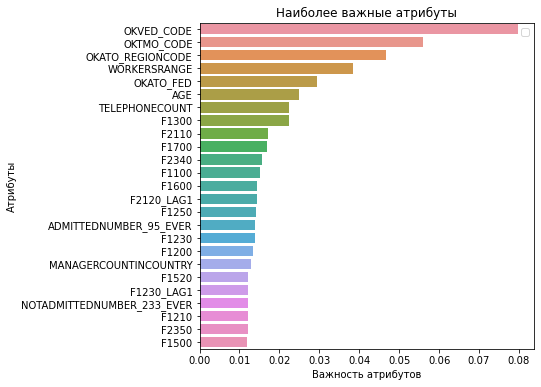

In [33]:
feature_importances(model_rf, X_train)

### 3.2 xgboost

Сделаем подбор параметров

In [34]:
%%time

parameters = {
    'max_depth':range(5, 20, 5),
    'learning_rate':np.arange(0.05, 0.4, 0.05)
}

gsearch2 = GridSearchCV(
            estimator=XGBClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=3
)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_

Fitting 3 folds for each of 21 candidates, totalling 63 fits


C:\Users\FED\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 46s


{'learning_rate': 0.35000000000000003, 'max_depth': 15}

In [35]:
model_xgb = XGBClassifier(max_depth=gsearch2.best_params_['max_depth'], 
                          learning_rate=gsearch2.best_params_['learning_rate'])
model_xgb.fit(X_train, y_train)

[00:07:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.35000000000000003,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
report(model_xgb, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8237
           1       0.99      0.99      0.99      6076

    accuracy                           0.99     14313
   macro avg       0.99      0.99      0.99     14313
weighted avg       0.99      0.99      0.99     14313

roc_auc_score 0.9993545797583329
Тестовые данные:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      2265
           1       0.89      0.57      0.69      1313

    accuracy                           0.82      3578
   macro avg       0.84      0.76      0.78      3578
weighted avg       0.83      0.82      0.80      3578

roc_auc_score 0.9095970167572031


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


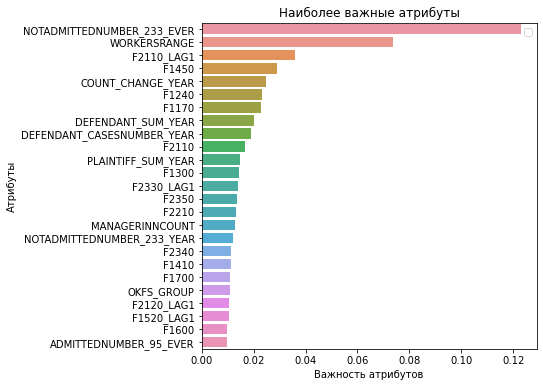

In [37]:
feature_importances(model_xgb, X_train)

### 3.3 lightgbm

Сделаем подбор параметров

In [38]:
%%time

parameters = {
    'n_estimators': range(50, 100, 10),
    'num_leaves': range(5, 50, 1),
#     'learning_rate': np.arange(0.05, 0.4, 0.05)
}

gsearch3 = GridSearchCV(
            estimator=LGBMClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=1
)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Wall time: 4min 31s


{'n_estimators': 80, 'num_leaves': 44}

In [39]:
model_lgbm = LGBMClassifier(n_estimators=gsearch3.best_params_['n_estimators'],
                           num_leaves=gsearch3.best_params_['num_leaves'],
                           )
model_lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=80, num_leaves=44)

In [40]:
report(model_lgbm, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      8237
           1       0.95      0.92      0.93      6076

    accuracy                           0.94     14313
   macro avg       0.95      0.94      0.94     14313
weighted avg       0.94      0.94      0.94     14313

roc_auc_score 0.9870576477643108
Тестовые данные:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87      2265
           1       0.88      0.58      0.70      1313

    accuracy                           0.82      3578
   macro avg       0.84      0.77      0.78      3578
weighted avg       0.83      0.82      0.81      3578

roc_auc_score 0.9224027344150616


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


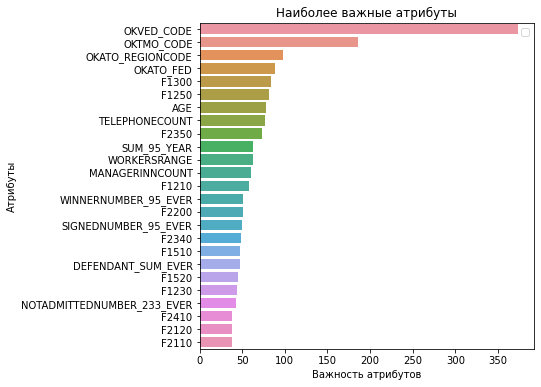

In [41]:
feature_importances(model_lgbm, X_train)

### 3.4 catboost

Подготовим данные (так как catboost непосредственно может работать с категориальными признаками, то label encoder не требуется)

In [42]:
train_cb = train_data.iloc[:train_size, :]
test_cb = train_data.iloc[train_size: , :]

print(train_cb.shape)
print(test_cb.shape)

X_train_cb = train_cb.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_train_cb = train_cb['TARGET']

X_test_cb = test_cb.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_test_cb = test_cb['TARGET']

(14313, 115)
(3578, 115)


Сделаем подбор параметров

In [43]:
# %%time

# param_grid = {
# #     'learning_rate': [0.05, 0.1],
#         'depth': [5, 10, 15],
#         'l2_leaf_reg': [4, 9, 14]}

# model_cb = CatBoostClassifier(cat_features = cat_features, loss_function='Logloss')


# grid_search_result = model_cb.grid_search(param_grid,
#                                        X=X_train_cb,
#                                        y=y_train_cb,
#                                        plot=True)

# grid_search_result['params']

In [44]:
# model_cb = CatBoostClassifier(depth=grid_search_result['params']['depth'],
# #                               learning_rate=grid_search_result['params']['learning_rate'],
#                               loss_function='Logloss',
#                               l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
#                               verbose=True,
#                               cat_features = cat_features)

model_cb = CatBoostClassifier(depth=15,
                              loss_function='Logloss',
                              l2_leaf_reg=4,
                              verbose=True,
                              cat_features = cat_features)

model_cb.fit(X_train_cb, y_train_cb)

0:	learn: 0.6625787	total: 9.81s	remaining: 2h 43m 24s
1:	learn: 0.6387874	total: 20.1s	remaining: 2h 46m 58s
2:	learn: 0.6170025	total: 29.1s	remaining: 2h 41m 14s
3:	learn: 0.5959709	total: 37.7s	remaining: 2h 36m 16s
4:	learn: 0.5756698	total: 46.5s	remaining: 2h 34m 7s
5:	learn: 0.5559211	total: 54.9s	remaining: 2h 31m 29s
6:	learn: 0.5377561	total: 1m 3s	remaining: 2h 30m 4s
7:	learn: 0.5240024	total: 1m 12s	remaining: 2h 29m 6s
8:	learn: 0.5084797	total: 1m 20s	remaining: 2h 28m 24s
9:	learn: 0.4936149	total: 1m 29s	remaining: 2h 27m 38s
10:	learn: 0.4787065	total: 1m 38s	remaining: 2h 27m 6s
11:	learn: 0.4653197	total: 1m 46s	remaining: 2h 26m 8s
12:	learn: 0.4529911	total: 1m 55s	remaining: 2h 26m 2s
13:	learn: 0.4415484	total: 2m 4s	remaining: 2h 25m 51s
14:	learn: 0.4294192	total: 2m 13s	remaining: 2h 25m 36s
15:	learn: 0.4205504	total: 2m 21s	remaining: 2h 25m 32s
16:	learn: 0.4104177	total: 2m 30s	remaining: 2h 25m 2s
17:	learn: 0.4007536	total: 2m 39s	remaining: 2h 25m 8s


145:	learn: 0.1495535	total: 20m 35s	remaining: 2h 27s
146:	learn: 0.1484286	total: 20m 44s	remaining: 2h 20s
147:	learn: 0.1479930	total: 20m 52s	remaining: 2h 11s
148:	learn: 0.1477220	total: 21m 1s	remaining: 2h 3s
149:	learn: 0.1470425	total: 21m 10s	remaining: 1h 59m 57s
150:	learn: 0.1468536	total: 21m 10s	remaining: 1h 59m 5s
151:	learn: 0.1463121	total: 21m 19s	remaining: 1h 58m 58s
152:	learn: 0.1455416	total: 21m 28s	remaining: 1h 58m 51s
153:	learn: 0.1454150	total: 21m 37s	remaining: 1h 58m 47s
154:	learn: 0.1451635	total: 21m 46s	remaining: 1h 58m 40s
155:	learn: 0.1446631	total: 21m 55s	remaining: 1h 58m 35s
156:	learn: 0.1441710	total: 22m 3s	remaining: 1h 58m 27s
157:	learn: 0.1439462	total: 22m 13s	remaining: 1h 58m 23s
158:	learn: 0.1435501	total: 22m 22s	remaining: 1h 58m 20s
159:	learn: 0.1432062	total: 22m 31s	remaining: 1h 58m 13s
160:	learn: 0.1424014	total: 22m 40s	remaining: 1h 58m 8s
161:	learn: 0.1418834	total: 22m 48s	remaining: 1h 57m 58s
162:	learn: 0.1408

286:	learn: 0.1090625	total: 38m 24s	remaining: 1h 35m 25s
287:	learn: 0.1087813	total: 38m 33s	remaining: 1h 35m 18s
288:	learn: 0.1085993	total: 38m 41s	remaining: 1h 35m 11s
289:	learn: 0.1083377	total: 38m 49s	remaining: 1h 35m 4s
290:	learn: 0.1080682	total: 38m 58s	remaining: 1h 34m 57s
291:	learn: 0.1078282	total: 39m 6s	remaining: 1h 34m 49s
292:	learn: 0.1076529	total: 39m 15s	remaining: 1h 34m 44s
293:	learn: 0.1074914	total: 39m 24s	remaining: 1h 34m 37s
294:	learn: 0.1072202	total: 39m 33s	remaining: 1h 34m 31s
295:	learn: 0.1069700	total: 39m 41s	remaining: 1h 34m 25s
296:	learn: 0.1067206	total: 39m 50s	remaining: 1h 34m 19s
297:	learn: 0.1065861	total: 40m	remaining: 1h 34m 14s
298:	learn: 0.1065778	total: 40m	remaining: 1h 33m 47s
299:	learn: 0.1064724	total: 40m 9s	remaining: 1h 33m 41s
300:	learn: 0.1060190	total: 40m 18s	remaining: 1h 33m 36s
301:	learn: 0.1056653	total: 40m 27s	remaining: 1h 33m 30s
302:	learn: 0.1056059	total: 40m 36s	remaining: 1h 33m 24s
303:	lea

426:	learn: 0.0800336	total: 57m 19s	remaining: 1h 16m 56s
427:	learn: 0.0798398	total: 57m 28s	remaining: 1h 16m 49s
428:	learn: 0.0796860	total: 57m 37s	remaining: 1h 16m 41s
429:	learn: 0.0794843	total: 57m 46s	remaining: 1h 16m 34s
430:	learn: 0.0793317	total: 57m 54s	remaining: 1h 16m 27s
431:	learn: 0.0791815	total: 58m 3s	remaining: 1h 16m 20s
432:	learn: 0.0790725	total: 58m 13s	remaining: 1h 16m 14s
433:	learn: 0.0787520	total: 58m 22s	remaining: 1h 16m 7s
434:	learn: 0.0785047	total: 58m 31s	remaining: 1h 16m
435:	learn: 0.0782166	total: 58m 40s	remaining: 1h 15m 53s
436:	learn: 0.0779629	total: 58m 48s	remaining: 1h 15m 46s
437:	learn: 0.0779459	total: 58m 49s	remaining: 1h 15m 28s
438:	learn: 0.0776662	total: 58m 57s	remaining: 1h 15m 20s
439:	learn: 0.0775764	total: 59m 6s	remaining: 1h 15m 13s
440:	learn: 0.0774970	total: 59m 14s	remaining: 1h 15m 5s
441:	learn: 0.0772538	total: 59m 22s	remaining: 1h 14m 58s
442:	learn: 0.0771226	total: 59m 31s	remaining: 1h 14m 50s
443:	

564:	learn: 0.0615762	total: 1h 16m 20s	remaining: 58m 46s
565:	learn: 0.0614593	total: 1h 16m 28s	remaining: 58m 38s
566:	learn: 0.0614256	total: 1h 16m 37s	remaining: 58m 31s
567:	learn: 0.0613241	total: 1h 16m 46s	remaining: 58m 23s
568:	learn: 0.0612876	total: 1h 16m 54s	remaining: 58m 15s
569:	learn: 0.0612069	total: 1h 17m 3s	remaining: 58m 7s
570:	learn: 0.0610420	total: 1h 17m 12s	remaining: 58m
571:	learn: 0.0609731	total: 1h 17m 20s	remaining: 57m 52s
572:	learn: 0.0608768	total: 1h 17m 29s	remaining: 57m 44s
573:	learn: 0.0608012	total: 1h 17m 38s	remaining: 57m 37s
574:	learn: 0.0607165	total: 1h 17m 46s	remaining: 57m 28s
575:	learn: 0.0606176	total: 1h 17m 55s	remaining: 57m 21s
576:	learn: 0.0605547	total: 1h 18m 3s	remaining: 57m 13s
577:	learn: 0.0603927	total: 1h 18m 12s	remaining: 57m 6s
578:	learn: 0.0603196	total: 1h 18m 21s	remaining: 56m 58s
579:	learn: 0.0603046	total: 1h 18m 29s	remaining: 56m 50s
580:	learn: 0.0601462	total: 1h 18m 38s	remaining: 56m 42s
581:	

704:	learn: 0.0513837	total: 1h 35m 13s	remaining: 39m 50s
705:	learn: 0.0513185	total: 1h 35m 22s	remaining: 39m 42s
706:	learn: 0.0512655	total: 1h 35m 30s	remaining: 39m 34s
707:	learn: 0.0511904	total: 1h 35m 39s	remaining: 39m 27s
708:	learn: 0.0511776	total: 1h 35m 48s	remaining: 39m 19s
709:	learn: 0.0511629	total: 1h 35m 57s	remaining: 39m 11s
710:	learn: 0.0511553	total: 1h 36m 5s	remaining: 39m 3s
711:	learn: 0.0511190	total: 1h 36m 14s	remaining: 38m 55s
712:	learn: 0.0510808	total: 1h 36m 23s	remaining: 38m 48s
713:	learn: 0.0510735	total: 1h 36m 31s	remaining: 38m 40s
714:	learn: 0.0510484	total: 1h 36m 40s	remaining: 38m 32s
715:	learn: 0.0510012	total: 1h 36m 49s	remaining: 38m 24s
716:	learn: 0.0509173	total: 1h 36m 57s	remaining: 38m 16s
717:	learn: 0.0509173	total: 1h 36m 57s	remaining: 38m 4s
718:	learn: 0.0508418	total: 1h 37m 6s	remaining: 37m 57s
719:	learn: 0.0508187	total: 1h 37m 15s	remaining: 37m 49s
720:	learn: 0.0507384	total: 1h 37m 24s	remaining: 37m 41s
7

844:	learn: 0.0435995	total: 1h 54m 57s	remaining: 21m 5s
845:	learn: 0.0435517	total: 1h 55m 6s	remaining: 20m 57s
846:	learn: 0.0435412	total: 1h 55m 6s	remaining: 20m 47s
847:	learn: 0.0435283	total: 1h 55m 15s	remaining: 20m 39s
848:	learn: 0.0434822	total: 1h 55m 23s	remaining: 20m 31s
849:	learn: 0.0434575	total: 1h 55m 32s	remaining: 20m 23s
850:	learn: 0.0434040	total: 1h 55m 41s	remaining: 20m 15s
851:	learn: 0.0433670	total: 1h 55m 49s	remaining: 20m 7s
852:	learn: 0.0433416	total: 1h 55m 58s	remaining: 19m 59s
853:	learn: 0.0432999	total: 1h 56m 6s	remaining: 19m 50s
854:	learn: 0.0432381	total: 1h 56m 15s	remaining: 19m 42s
855:	learn: 0.0432278	total: 1h 56m 23s	remaining: 19m 34s
856:	learn: 0.0432160	total: 1h 56m 32s	remaining: 19m 26s
857:	learn: 0.0431763	total: 1h 56m 41s	remaining: 19m 18s
858:	learn: 0.0431219	total: 1h 56m 49s	remaining: 19m 10s
859:	learn: 0.0430793	total: 1h 56m 58s	remaining: 19m 2s
860:	learn: 0.0430437	total: 1h 57m 7s	remaining: 18m 54s
861:

987:	learn: 0.0386271	total: 2h 14m 31s	remaining: 1m 38s
988:	learn: 0.0385960	total: 2h 14m 39s	remaining: 1m 29s
989:	learn: 0.0385888	total: 2h 14m 48s	remaining: 1m 21s
990:	learn: 0.0385809	total: 2h 14m 56s	remaining: 1m 13s
991:	learn: 0.0384991	total: 2h 15m 5s	remaining: 1m 5s
992:	learn: 0.0384635	total: 2h 15m 14s	remaining: 57.2s
993:	learn: 0.0384512	total: 2h 15m 23s	remaining: 49s
994:	learn: 0.0383931	total: 2h 15m 31s	remaining: 40.9s
995:	learn: 0.0383573	total: 2h 15m 40s	remaining: 32.7s
996:	learn: 0.0383467	total: 2h 15m 48s	remaining: 24.5s
997:	learn: 0.0383372	total: 2h 15m 57s	remaining: 16.3s
998:	learn: 0.0382497	total: 2h 16m 6s	remaining: 8.17s
999:	learn: 0.0382019	total: 2h 16m 15s	remaining: 0us


In [45]:
report(model_cb, y_train_cb, y_test_cb, X_train_cb, X_test_cb)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      8237
           1       0.98      0.96      0.97      6076

    accuracy                           0.97     14313
   macro avg       0.97      0.97      0.97     14313
weighted avg       0.97      0.97      0.97     14313

roc_auc_score 0.9954647948853592
Тестовые данные:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      2265
           1       0.92      0.60      0.73      1313

    accuracy                           0.83      3578
   macro avg       0.86      0.79      0.80      3578
weighted avg       0.85      0.83      0.82      3578

roc_auc_score 0.933663030082937


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


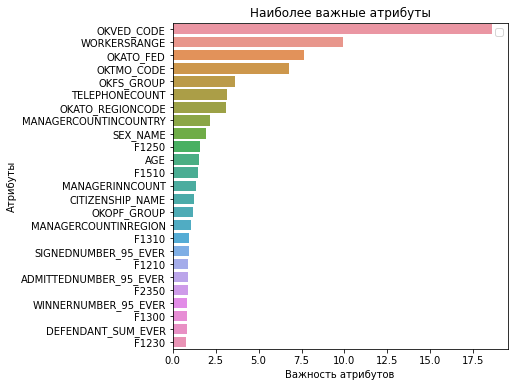

In [46]:
feature_importances(model_cb, X_train_cb)

## 4 Результаты

Формируем файл с результатами, используем модели lightgbm и catboost

In [47]:
res_cb = model_cb.predict_proba(test_data.drop(['id_contract', 'id_client', 'SIGN_DATE'], axis=1))[:, 1]
res_lgbm = model_lgbm.predict_proba(test_data_le.drop(['id_contract', 'id_client', 'SIGN_DATE'], axis=1))[:, 1]

In [48]:
df_cb = pd.DataFrame({'id_contract': test_data.id_contract.values, 'TARGET': res_cb})
df_lgbm = pd.DataFrame({'id_contract': test_data_le.id_contract.values, 'TARGET': res_lgbm})


df_cb.to_csv('../data/processed/res_cb.csv', sep=';', index=False)
df_lgbm.to_csv('../data/processed/res_lgbm.csv', sep=';', index=False)